## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

## Load the Dataset

In [2]:
data = pd.read_csv('Yulu.csv')

In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['lag_count'] = data['count'].shift(1)
data['temp_humidity'] = data['temp'] * data['humidity']
data['temp_windspeed'] = data['temp'] * data['windspeed']

## Correlation Analysis: Bike Rentals vs Season


Correlation between Bike Rentals and Season: 0.1634


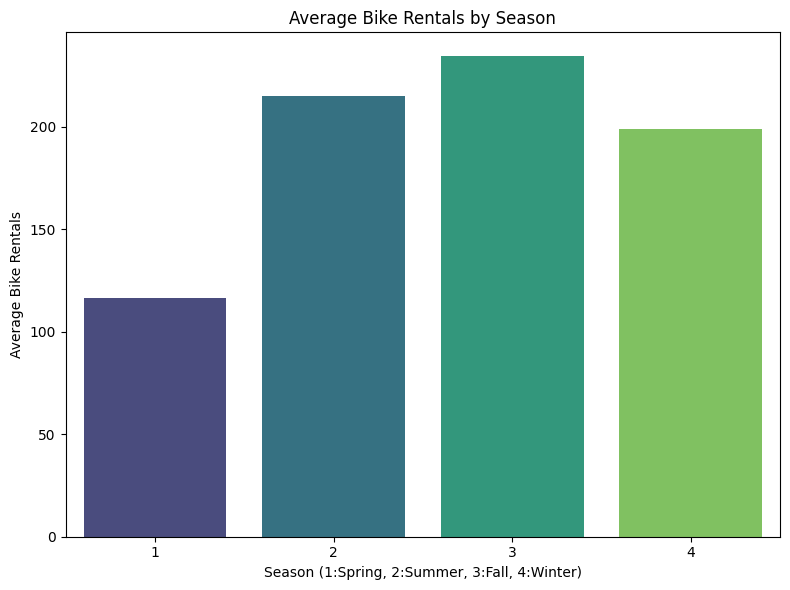

In [4]:
season_counts = data.groupby('season')['count'].mean().reset_index()
season_correlation = data['season'].corr(data['count'])
print(f"\nCorrelation between Bike Rentals and Season: {season_correlation:.4f}")

plt.figure(figsize=(8, 6))
sns.barplot(x='season', y='count', data=season_counts, palette='viridis')
plt.xlabel('Season (1:Spring, 2:Summer, 3:Fall, 4:Winter)')
plt.ylabel('Average Bike Rentals')
plt.title('Average Bike Rentals by Season')
plt.tight_layout()
plt.savefig('bike_rentals_by_season.png')
plt.show()

## Correlation Analysis: Bike Rentals vs Time of Day

Correlation between Bike Rentals and Hour of Day: 0.4006


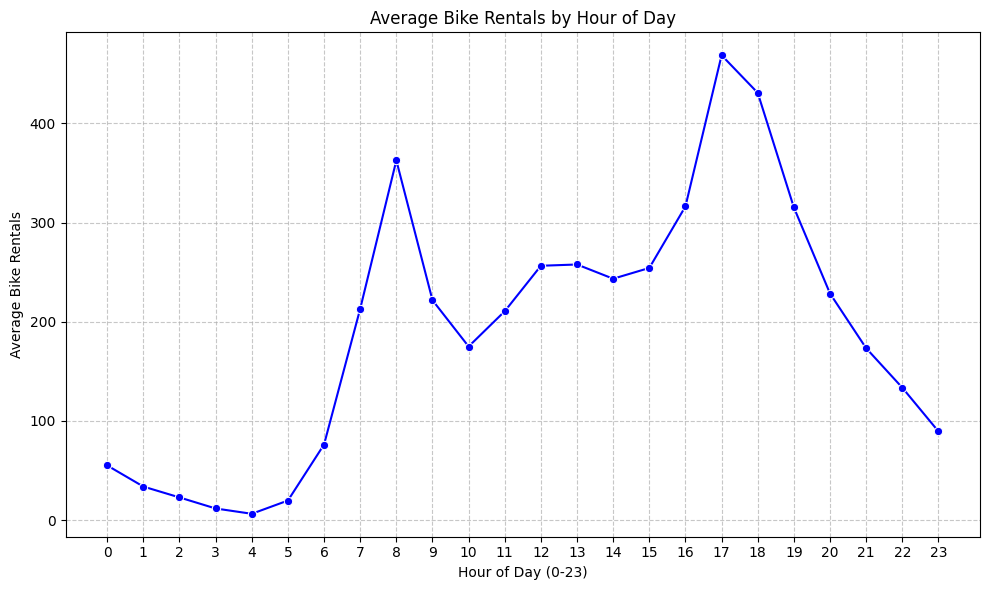

In [5]:
hour_counts = data.groupby('hour')['count'].mean().reset_index()
hour_correlation = data['hour'].corr(data['count'])
print(f"Correlation between Bike Rentals and Hour of Day: {hour_correlation:.4f}")

plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='count', data=hour_counts, marker='o', color='blue')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Bike Rentals')
plt.title('Average Bike Rentals by Hour of Day')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('bike_rentals_by_hour.png')
plt.show()

## Data Preprocessing

In [6]:
data = data.dropna()  
data = pd.get_dummies(data, columns=['season', 'weather', 'holiday', 'workingday'], drop_first=True)
data['count'] = data['count'].clip(upper=data['count'].quantile(0.995))

In [7]:
features = ['hour_sin', 'hour_cos', 'temp', 'humidity', 'windspeed', 'dayofweek', 'month', 'lag_count', 
            'temp_humidity', 'temp_windspeed'] + \
           [col for col in data.columns if col.startswith(('season_', 'weather_', 'holiday_', 'workingday_'))]
X = data[features]
y = data['count']

In [8]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

## Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'rf__n_estimators': [200, 300, 400],
    'rf__max_depth': [15, 20, 25],
    'rf__min_samples_split': [5, 10],
    'rf__min_samples_leaf': [1, 2]
}
random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=10, cv=3, scoring='r2', 
                                   n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('rf',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'rf__max_depth': [15, 20, 25],
                                        'rf__min_samples_leaf': [1, 2],
                                        'rf__min_samples_split': [5, 10],
                                        'rf__n_estimators': [200, 300, 400]},
                   random_state=42, scoring='r2', verbose=1)

## Model Evaluation

In [18]:
best_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\nModel Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
cv_scores = cross_val_score(best_model, X, y, cv=3, scoring='r2')
print(f"\nCross-Validation R² Scores: {cv_scores}")
print(f"Average CV R²: {cv_scores.mean():.4f} (± {cv_scores.std() * 2:.4f})")

Best Parameters: {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': 25}

Model Performance:
MSE: 1275.45
RMSE: 35.71
MAE: 22.65
R²: 0.9624

Cross-Validation R² Scores: [0.92567586 0.94040067 0.88998278]
Average CV R²: 0.9187 (± 0.0423)


## Visualization: Actual vs Predicted

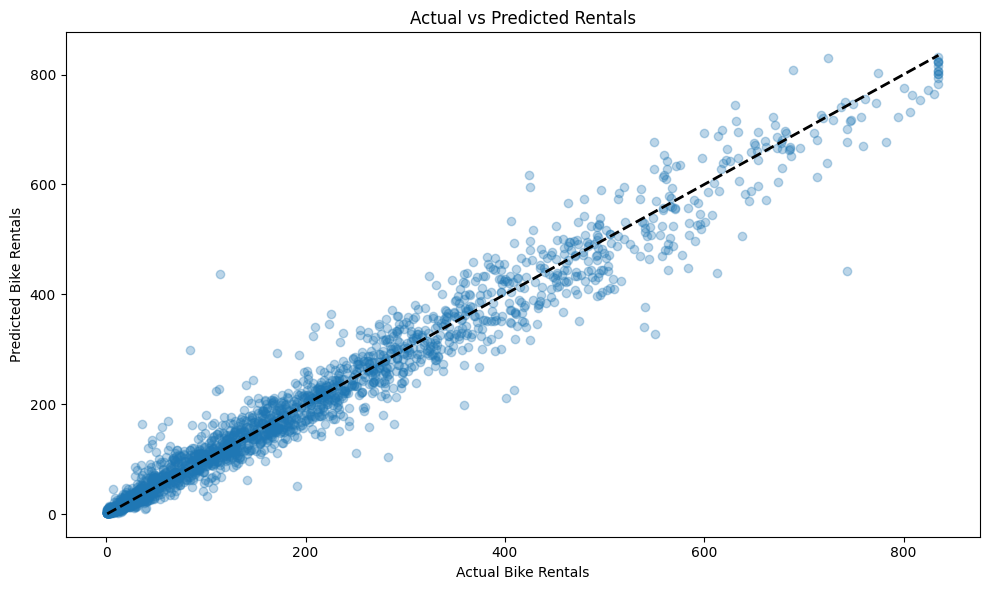

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Bike Rentals')
plt.ylabel('Predicted Bike Rentals')
plt.title('Actual vs Predicted Rentals')
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()